In [ ]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import pandas as pd
import shutil
import torch

In [153]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

#### Preprocessing

In [ ]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [ ]:
idm = idm.drop_duplicates("bps_kelurahan_kode")

In [ ]:
idm.groupby("status").count()

In [ ]:
idm[idm.bps_kelurahan_kode ==3209100011]

In [ ]:
3290+1631+270+121

In [ ]:
os.chdir('C:/Users/jwst2/Python/tesis/jpg/IDM/01. Desa Sentinel 10m TC')
if os.path.isdir('jabar_idm/MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')


In [ ]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general desa sentinel 10m tc/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/01. Desa Sentinel 10m TC'

In [ ]:

from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].empty):
            if(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

#### Models

In [ ]:
path = Path.cwd() / (destpath)

In [ ]:
Path.BASE_PATH = path
path.ls()

In [ ]:
fname = (path/"TERTINGGAL BERKEMBANG").ls()[0]
fname

In [ ]:
img = Image.open(fname)
img

In [ ]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)

In [ ]:
dls = blocks.dataloaders(path,bs= 10)

In [ ]:
dls.show_batch(nrows=1, ncols=5)

#### Densenet

In [130]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s,roca]

In [131]:
learn = cnn_learner(dls, densenet121, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0004786300996784121)

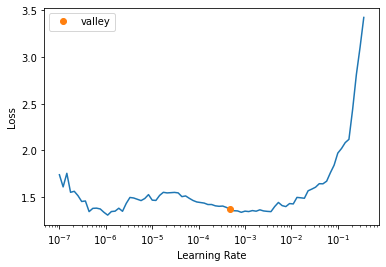

In [132]:
learn.lr_find()

In [133]:
learn.fit_one_cycle(5, lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.062078,0.934649,0.619586,0.610755,0.600875,0.610755,0.599470,0.631592,01:47
1,0.821012,0.767153,0.655367,0.506553,0.542558,0.506553,0.434176,0.560953,01:53
2,0.679203,0.677285,0.700565,0.574573,0.715432,0.574573,0.551685,0.638287,01:55
3,0.608937,0.581805,0.708098,0.599217,0.696640,0.599217,0.593429,0.669262,01:56
4,0.605659,0.576572,0.717514,0.617165,0.705169,0.617165,0.618022,0.687100,01:57


In [139]:
learn.fit_one_cycle(1, lr_max = 1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.621807,0.573415,0.736347,0.649003,0.725431,0.649003,0.657318,0.699573,01:47


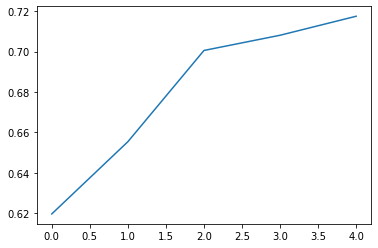

In [134]:
plt.plot(L(learn.recorder.values).itemgot(2));

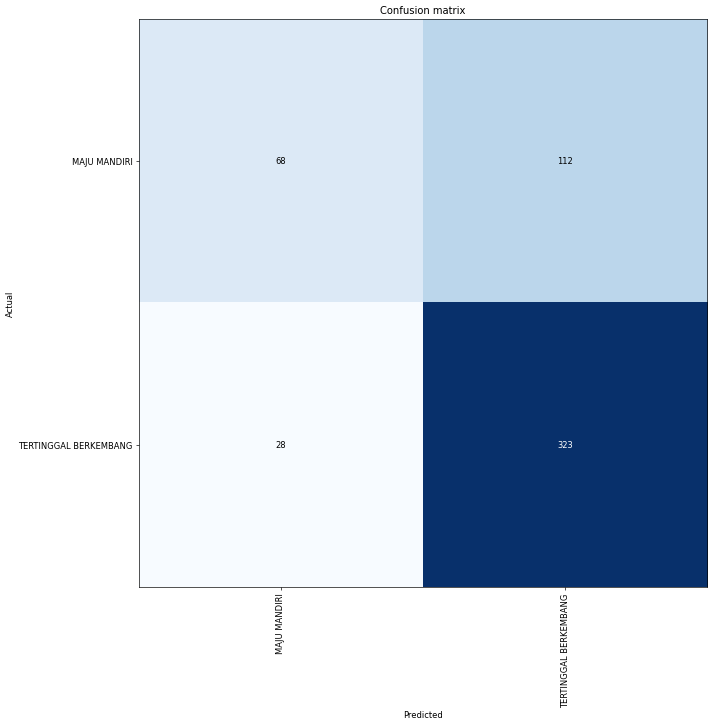

In [140]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(6, figsize=(15,11))

In [142]:
learn.export('C:/Users/jwst2/Python/tesis/idm/models/Desa densenet sentinel 10m TC.pkl')

#### Resnet

In [143]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=1.737800812406931e-05)

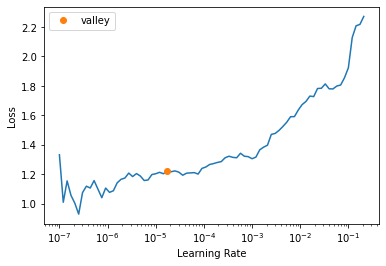

In [144]:
learn_rs.lr_find()

In [145]:
learn_rs.fit_one_cycle(5, lr_max = 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.092717,0.812144,0.649718,0.580769,0.594092,0.580769,0.582547,0.575989,01:26
1,0.684365,0.664800,0.644068,0.595442,0.598565,0.595442,0.596688,0.657265,01:31
2,0.624303,0.610990,0.689266,0.612037,0.644377,0.612037,0.615954,0.659133,01:37
3,0.576427,0.575683,0.708098,0.627635,0.672973,0.627635,0.633158,0.711222,01:39
4,0.481275,0.602100,0.677966,0.630556,0.636587,0.630556,0.632927,0.705286,01:40


In [147]:
learn_rs.fit_one_cycle(1, lr_max = 1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.547386,0.590417,0.693032,0.644658,0.653425,0.644658,0.647960,0.707787,01:31


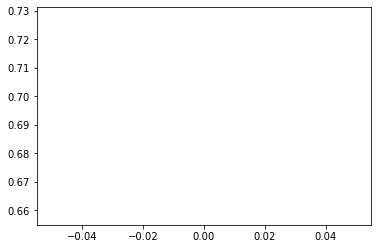

In [148]:
plt.plot(L(learn_rs.recorder.values).itemgot(2));

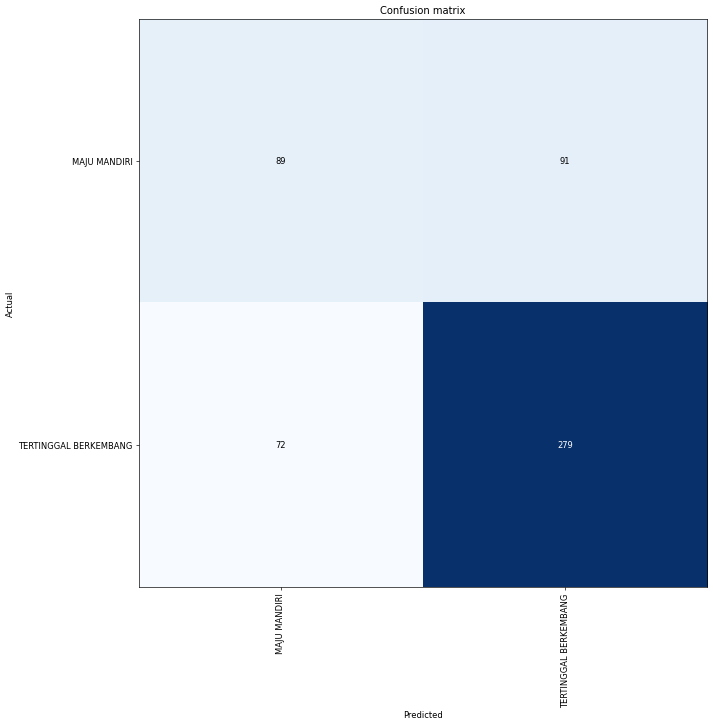

In [149]:
interp = ClassificationInterpretation.from_learner(learn_rs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [150]:
learn_rs.export('C:/Users/jwst2/Python/tesis/idm/models/Desa resnet sentinel 10m TC.pkl')

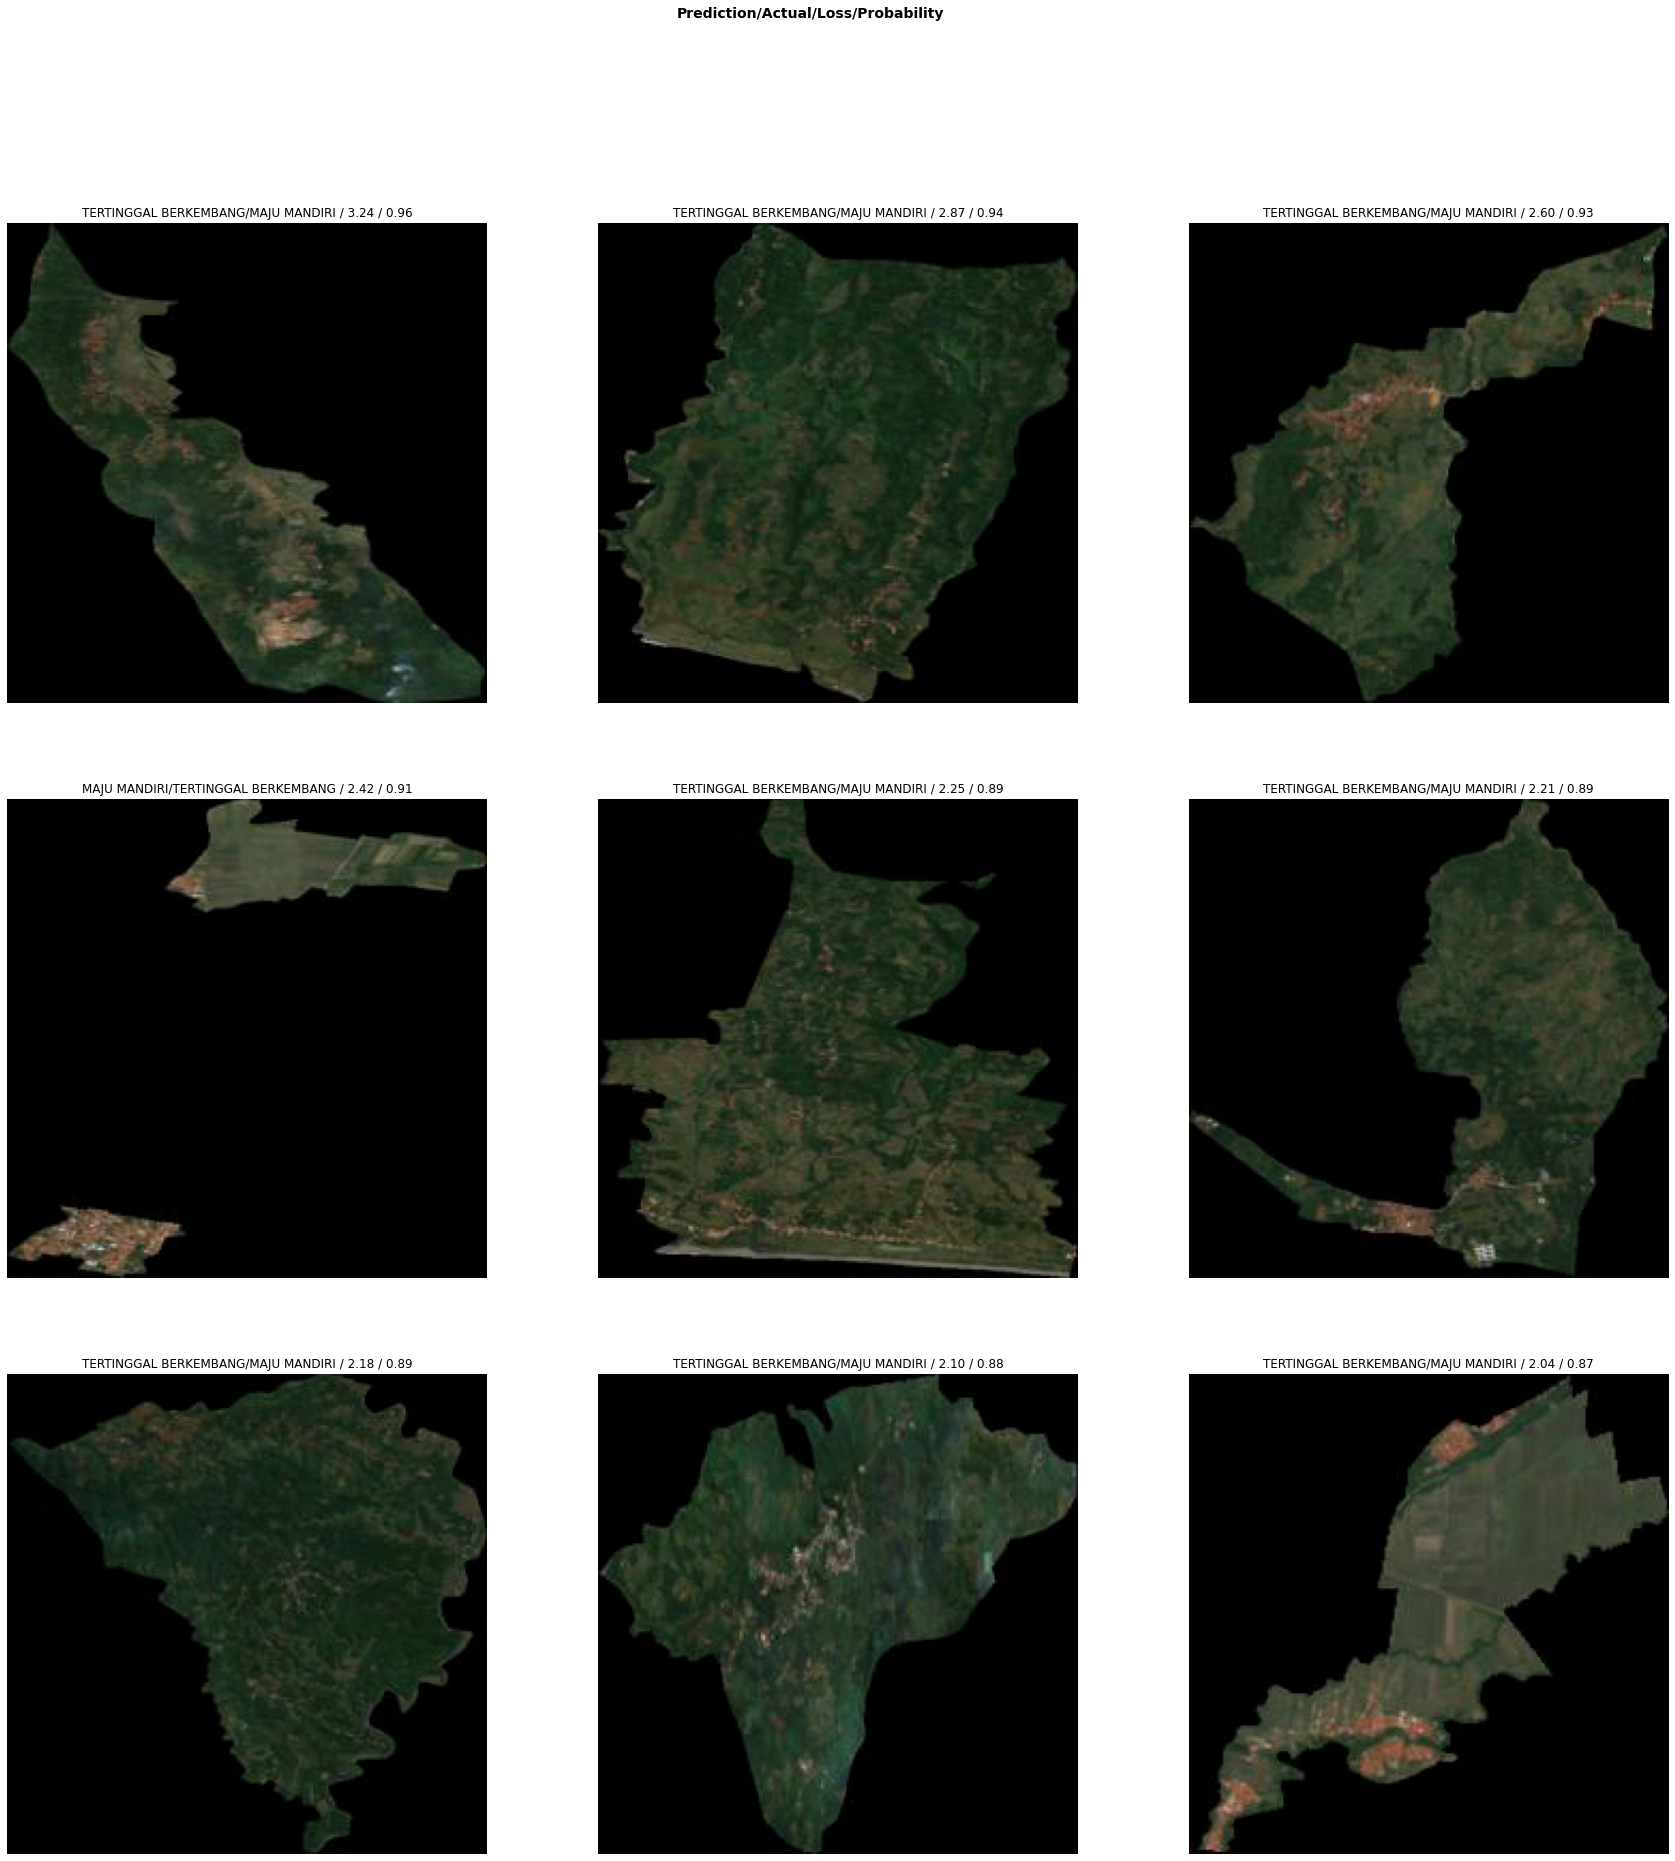

In [152]:
interp.plot_top_losses(16, figsize=(30,30))